# `GeoTensor` `numpy` API

* Author: Gonzalo Mateo-García

This tutorial shows how to operate with the `numpy` API with `GeoTensor` objects. The `GeoTensor` class is a subclass of `np.ndarray` that stores the spatial affine transform, the coordinate reference system and no data value (called `fill_value_default`). When a `GeoTensor` is sliced, its `transform` attribute is shifted accordingly. Additionally its transform is also shifted if the `GeoTensor` is padded. `GeoTensor`s are restricted to be 2D, 3D or 4D arrays and their two last dimensions are assumed to be the `y` and `x` spatial axis.

As a subclass of `np.ndarray`, operations with `GeoTensor` objects work similar than operations with `np.ndarray`s. However, there are some restrictions that we have implemented to keep consistency with the `GeoTensor` concept. If you need to use the `numpy` implementation you can access the bare `numpy` object with the `.values` attribute. Below there's a list with restrictions on `numpy` operations:

1. Slicing a `GeoTensor` is more restrictive than a `numpy` array. It only allows to slice with `lists`, numbers or `slice`s. In particular the spatial dimensions can only be sliced with `slice`s. Slicing for inplace modification is not restricted (i.e. you can slice with boolean arrays to modify certain values of the object).
2. Binary operations (such as add, multiply etc) check for `GeoTensor` inputs if they have the `same_extent`; that is, same `transform` `crs` and spatial dimensions (`width` and `height`).
3. `squeeze`, `expand_dims` and `transpose` make sure spatial dimensions (last two axes) are not modified and kept at the end of the array.
4. `concatenate` and `stack` make sure all operated `GeoTensor`s have `same_extent` and `shape`. `concatenate` does not allow to concatenate on the spatial dims.
5. Reductions (such as `np.mean` or `np.all`) return `GeoTensor` object if the spatial dimensions are preserved and `np.ndarray` or scalars otherwise.


In [1]:
# From ml4floods: https://spaceml-org.github.io/ml4floods/content/ml4ops/HOWTO_Run_Inference_multioutput_binary.html
# from huggingface_hub import hf_hub_url
# subset = "test"
# filename = "EMSR264_18MIANDRIVAZODETAIL_DEL_v2"

# s2url = hf_hub_url(repo_id="isp-uv-es/WorldFloodsv2",
#                    subfolder=f"{subset}/S2", filename=f"{filename}.tif",
#                    repo_type="dataset")
# print(s2url)

## Load some sample data

In [2]:
from georeader import plot
from georeader.geotensor import GeoTensor
from georeader import save
import os

s2url = "https://huggingface.co/datasets/isp-uv-es/WorldFloodsv2/resolve/main/test/S2/EMSR264_18MIANDRIVAZODETAIL_DEL_v2.tif"
filelocal = os.path.basename(s2url)
if not os.path.exists(filelocal):
    s2img = GeoTensor.load_file(s2url)
    save.save_tiled_geotiff(s2img, filelocal)
else:
    s2img = GeoTensor.load_file(filelocal)

# Set nodata value to zero
s2img.fill_value_default = 0
s2img

 
         Transform: | 10.00, 0.00, 537430.00|
| 0.00,-10.00, 7844180.00|
| 0.00, 0.00, 1.00|
         Shape: (15, 1313, 1530)
         Resolution: (10.0, 10.0)
         Bounds: (537430.0, 7831050.0, 552730.0, 7844180.0)
         CRS: EPSG:32738
         fill_value_default: 0
        

## Padding and slicing as with `numpy` arrays

In [3]:
s2img = s2img.pad(((0,0), (25, 25), (10, 10)))

[(0, 0), (25, 25), (10, 10)]


<Axes: >

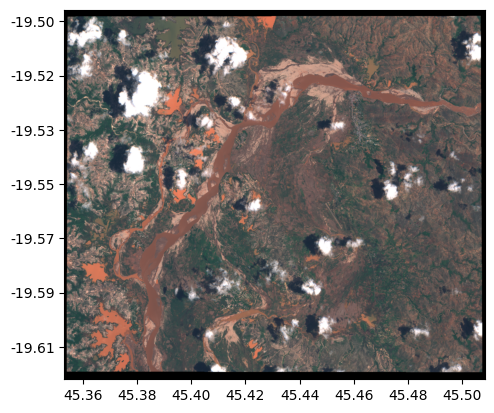

In [4]:
rgb = (s2img[[3,2,1]] / 3_500).clip(0,1)
plot.show(rgb)

## `validmask` and `invalidmask` methods

<Axes: >

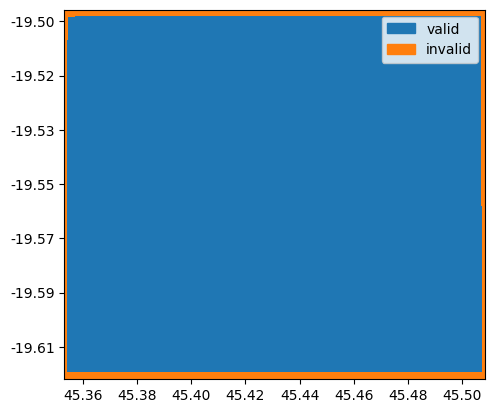

In [20]:
invalids = np.all(s2img.invalidmask(),axis=0) 

assert isinstance(invalids, GeoTensor), "invalids is of class GeoTensor!"

plot.plot_segmentation_mask(invalids, interpretation_array=["valid", "invalid"],
                           color_array=["C0","C1"])

## Slicing propagates the affine transform

In [5]:
rgb_slice = rgb[:, 20:300, 50:340]
rgb_slice

 
         Transform: | 10.00, 0.00, 537830.00|
| 0.00,-10.00, 7844230.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 280, 290)
         Resolution: (10.0, 10.0)
         Bounds: (537830.0, 7841430.0, 540730.0, 7844230.0)
         CRS: EPSG:32738
         fill_value_default: 0
        

In [6]:
assert rgb_slice.transform != rgb.transform, f"Different transform"

rgb_slice.transform, rgb.transform

(Affine(10.0, 0.0, 537830.0,
        0.0, -10.0, 7844230.0),
 Affine(10.0, 0.0, 537330.0,
        0.0, -10.0, 7844430.0))

<Axes: >

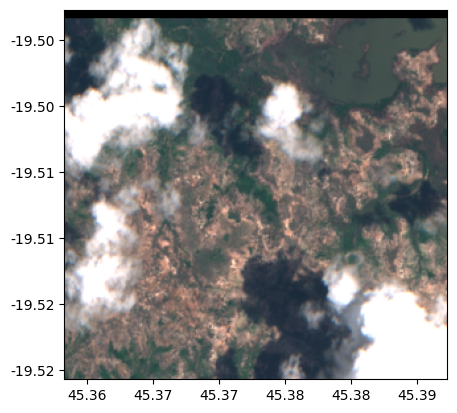

In [7]:
plot.show(rgb_slice)

## `np.mean` and other reduction ops return `GeoTensor` 
When reduction axis are not the spatial axis, the returned object is a `GeoTensor`

In [8]:
import numpy as np

greyimg = np.mean(rgb, axis=0)
greyimg

 
         Transform: | 10.00, 0.00, 537330.00|
| 0.00,-10.00, 7844430.00|
| 0.00, 0.00, 1.00|
         Shape: (1363, 1550)
         Resolution: (10.0, 10.0)
         Bounds: (537330.0, 7830800.0, 552830.0, 7844430.0)
         CRS: EPSG:32738
         fill_value_default: 0
        

<Axes: >

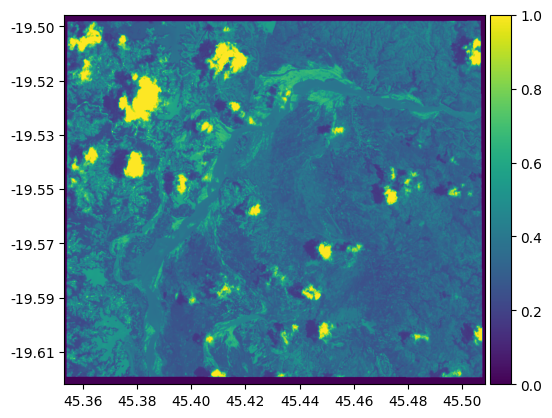

In [9]:
plot.show(greyimg, add_colorbar_next_to=True)

When reducing over the spatial axis, return object is `np.ndarray`:

In [10]:
average_reflectance_band = np.mean(rgb, axis=(-2,-1))
average_reflectance_band

array([0.39475575, 0.36224817, 0.34591881])

## vectorized `ufuncs`

In [11]:
greyimg_sin = np.sin(greyimg)
greyimg_sin

 
         Transform: | 10.00, 0.00, 537330.00|
| 0.00,-10.00, 7844430.00|
| 0.00, 0.00, 1.00|
         Shape: (1363, 1550)
         Resolution: (10.0, 10.0)
         Bounds: (537330.0, 7830800.0, 552830.0, 7844430.0)
         CRS: EPSG:32738
         fill_value_default: 0
        

## Ops of `GeoTensor` with numbers and `np.ndarray`

<Axes: >

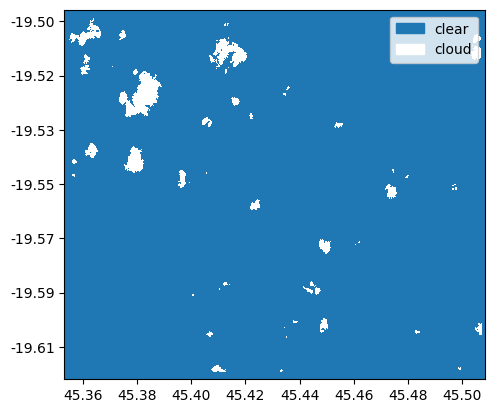

In [12]:
clouds = greyimg >= .9
plot.plot_segmentation_mask(clouds, interpretation_array=["clear","cloud"], 
                            color_array=["C0", "white"])

In [13]:
cloud_percentage = np.mean(clouds)
cloud_percentage

0.022976830047570587

## Example: normalize by bands

<Axes: >

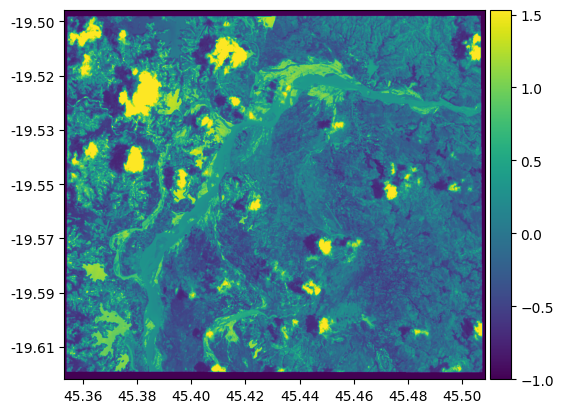

In [14]:
average_reflectance_band = np.mean(rgb, axis=(-2,-1), keepdims=True)
std_reflectance = np.mean(rgb, axis=(-2,-1), keepdims=True)

rgb_norm = (rgb - average_reflectance_band) / std_reflectance
plot.show(rgb_norm[0], add_colorbar_next_to=True)

## Computing RS indexes

/home/gonzalo/git/georeader/georeader/geotensor.py:500: RuntimeWarning: invalid value encountered in divide
  result_values = self.values / other


<Axes: >

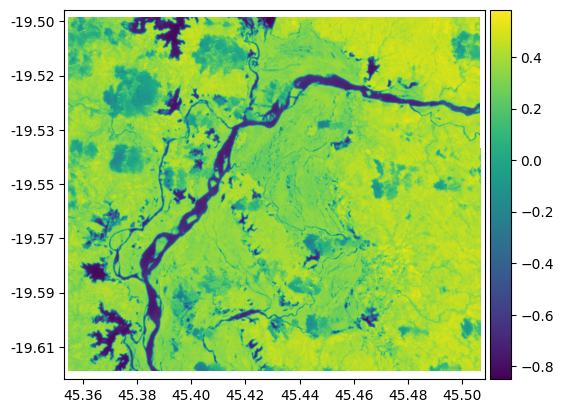

In [15]:
b11 = s2img[11].astype(np.float64)
b3 = s2img[2].astype(np.float64)

mndwi = (b11 - b3) / (b11 + b3)
plot.show(mndwi, add_colorbar_next_to=True)

<Axes: >

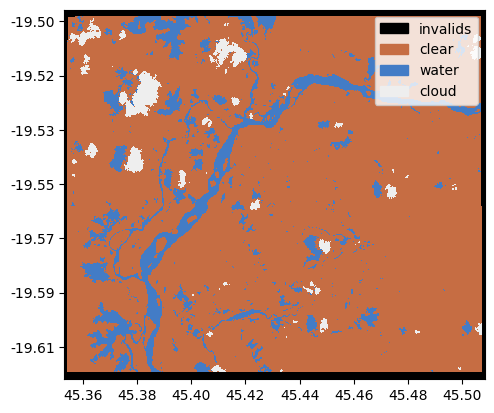

In [16]:
water = mndwi < 0
land_water_clouds = GeoTensor(np.ones(clouds.shape, dtype=np.uint8),
                              fill_value_default=0,
                              crs=clouds.crs,
                              transform=clouds.transform)

land_water_clouds[water] = 2
land_water_clouds[clouds] = 3
land_water_clouds[invalids] = 0

plot.plot_segmentation_mask(land_water_clouds, 
                            interpretation_array=["invalids","clear","water","cloud"], 
                            color_array=["#000000","#c66d43","#437cc6","#eeeeee"])


## `.values` attribute returns a view of the object as `np.ndarray`

In [17]:
clouds.values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Apply function that expects `np.ndarray` objects

We can pass a `GeoTensor` to any function that expects `np.ndarray`. Depending on the function the return type may be a `GeoTensor` or a `np.ndarray`. If the return type is `np.ndarray` we can wrap the data with `array_as_geotensor` method:

In [30]:
from scipy import ndimage as ndi

greyimg_smoothed = ndi.gaussian_filter(greyimg, sigma=5, cval=0, mode="reflect")
greyimg_smoothed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Axes: >

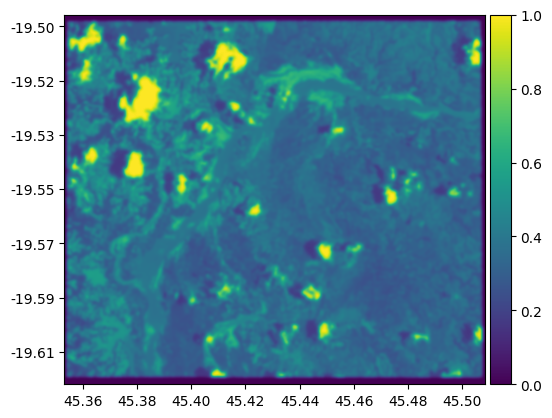

In [31]:
greyimg_smoothed = rgb.array_as_geotensor(greyimg_smoothed)
plot.show(greyimg_smoothed, add_colorbar_next_to=True)

## Licence
The georeader package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

`georeader` tutorials and notebooks are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).

 If you find this work useful please cite:

```
@article{portales-julia_global_2023,
	title = {Global flood extent segmentation in optical satellite images},
	volume = {13},
	issn = {2045-2322},
	doi = {10.1038/s41598-023-47595-7},
	number = {1},
	urldate = {2023-11-30},
	journal = {Scientific Reports},
	author = {Portalés-Julià, Enrique and Mateo-García, Gonzalo and Purcell, Cormac and Gómez-Chova, Luis},
	month = nov,
	year = {2023},
	pages = {20316},
}
```